# sumaryzacja tekstu

In [1]:
from google.colab import drive


drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!nvidia-smi

Mon Jan 26 16:40:22 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install "datasets<3.0.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.


In [3]:
!pip install bert-extractive-summarizer

In [4]:
!pip install pytorch-ignite
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 11.2 MB/s eta 0:00:00


## importowanie datesetu

In [9]:
from datasets import load_dataset


ds = load_dataset("EdinburghNLP/xsum", trust_remote_code=True)
ds= ds.filter(lambda example: len(example["document"]) < 750)
split_result = ds["test"].train_test_split(test_size=2, seed=42)
shots = split_result["test"]
ds["test"] = split_result["train"]

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Filter:   0%|          | 0/204045 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11332 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11334 [00:00<?, ? examples/s]

In [10]:
print(ds)
print(shots)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 32053
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 1746
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 1727
    })
})
Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 2
})


In [21]:
from summarizer import Summarizer
model = Summarizer()

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [11]:
from ignite.metrics import Rouge

m = Rouge(variants=["L", 1], multiref="best")

candidate = "the cat is not there".split()
references = [
    "the cat is on the mat".split(),
    "there is a cat on the mat".split()
]

m.update(([candidate], [references]))

print(m.compute())

{'Rouge-L-P': 0.6, 'Rouge-L-R': 0.5, 'Rouge-L-F': 0.5, 'Rouge-1-P': 0.8, 'Rouge-1-R': 0.5714285714285714, 'Rouge-1-F': 0.5714285714285714}


In [12]:
num_workers = 1
batch_size = 3

In [13]:
from torch.utils.data import DataLoader
import torch
test_dataset = ds["test"].select(range(10))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
print(test_dataset)


Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 10
})


In [14]:
import string


def clean(text):
    if not text:
        return ["."]
    text = text.lower().translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )
    return text.split()


def rouge_score_loss(
    batch,
    model,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
    m=Rouge(variants=["L", 2], multiref="best"),
):
    if bert:
        predictions = [
            model(doc, ratio=0.1) for doc in batch["document"]
        ]
    else:
        docs = [doc for doc in batch["document"]]

        prompted = [
            f"{prompt}{doc}{promptsuff}" for doc in batch["document"]
        ]
        inputs = tokenizer(
            prompted,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=4096,
        )

        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        summary_ids = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=50,
            do_sample=True,
            top_k=0,
            temperature=0.5,
        )

        input_length = inputs["input_ids"].shape[1]
        new_tokens = summary_ids[:, input_length:]

        predictions = tokenizer.batch_decode(
            new_tokens, skip_special_tokens=True
        )

    print(f"Doc: {batch['document'][0][:100]}")
    print(f"Prediction: {predictions[0]}")
    print(f"Target: {batch['summary'][0]}")

    predictions = [
        clean(pred) if pred.strip() else "." for pred in predictions
    ]

    targets = [[clean(ref)] for ref in batch["summary"]]

    print(predictions)
    print(targets)

    m.update((predictions, targets))
    print(m.compute())
    return m.compute()

In [15]:
from matplotlib import pyplot as plt
import numpy as np

def plot_data(data, labels=['Rouge-1-P', 'Rouge-1-R', 'Rouge-1-F','Rouge-2-P', 'Rouge-2-R', 'Rouge-2-F',  'Rouge-L-P', 'Rouge-L-R', 'Rouge-L-F', ]):
    x = np.arange(len(labels))
    width = 0.2

    plt.figure(figsize=(10, 6))
    for i, row in enumerate(data):
        offset = x + (i * width)
        plt.bar(offset, row, width=width, label=f'Model {i+1}')
    center_offset = ((len(data) - 1) * width) / 2
    plt.xticks(x + center_offset, labels)

    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('ROUGE Score Comparison')
    plt.legend()
    plt.show()

In [16]:
def batch_to_device(batch: dict, device) -> dict:
    return {k: v.to(device) for k, v in batch.items()}

In [17]:
import torch
import torch.nn as nn
from torch import Tensor
def calc_loss_batch(batch: dict, model: nn.Module) -> Tensor:
    logits = model(batch['input_ids'])
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), batch['labels'].flatten())
    return loss

In [18]:
import numpy as np
def calc_loss_loader(
    data_loader,
    model,
    device,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
) -> float:
    results = []

    for i, batch in enumerate(data_loader):

        m = Rouge(variants=[1,2,"L"], multiref="best")

        ret = rouge_score_loss(
            batch,
            model,
            bert,
            tokenizer,
            prompt,
            promptsuff,
            m,
        )
        results.append(list(ret.values()))

    results = np.array(results)
    return np.mean(results, axis=0)


In [19]:
def evaluate_model(
    model: nn.Module,
    loader: DataLoader,
    device,
    bert: bool,
    tokenizer: any,
    prompt: str = "",
    promptsuff: str = "",
) -> tuple[float, float]:
    if not bert:
        model.eval()

    with torch.no_grad():
        loss = calc_loss_loader(
            loader,
            model,
            device,
            bert=bert,
            tokenizer=tokenizer,
            prompt=prompt,
            promptsuff=promptsuff,
        )

    return loss




In [22]:
from torch import nn
loss = evaluate_model(model, test_loader, device='cuda', bert=True, tokenizer=None)
print(loss)



Doc: Edward Furneaux, 74, died after crashing his car into a tree in Kewstoke Road, Worle, on the morning
Prediction: Edward Furneaux, 74, died after crashing his car into a tree in Kewstoke Road, Worle, on the morning of 19 January. The body of his 70-year-old wife, Anne, was found at a property in Pilgrim's Way the same day.
Target: A husband and wife who died in an apparent murder-suicide in North Somerset have been named.
[['edward', 'furneaux', '74', 'died', 'after', 'crashing', 'his', 'car', 'into', 'a', 'tree', 'in', 'kewstoke', 'road', 'worle', 'on', 'the', 'morning', 'of', '19', 'january', 'the', 'body', 'of', 'his', '70', 'year', 'old', 'wife', 'anne', 'was', 'found', 'at', 'a', 'property', 'in', 'pilgrim', 's', 'way', 'the', 'same', 'day'], ['london', 'fire', 'brigade', 'said', 'it', 'was', 'called', 'to', 'the', 'arena', 'on', 'millennium', 'way', 'greenwich', 'at', 'about', '11', '15', 'bst', 'station', 'manager', 'martin', 'freeman', 'said', 'it', 'did', 'create', 'a', 'l

In [23]:
def generate_prompt(tokenizer, size):
    prompt = ""
    shots = ds["train"].train_test_split(train_size=4, seed=35)["train"]
    shots_loader = DataLoader(shots, batch_size=100000, shuffle=True, num_workers=num_workers)
    for batch in shots_loader:
        for i in range(len(batch['document'])):
            prompt += "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer."
            prompt += f'[TEXT]{batch['document'][i]}[AGENT]{batch['summary'][i]}'
            prompt += tokenizer.eos_token + "\n"
    prompt += "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
    return prompt


In [24]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer3 = AutoTokenizer.from_pretrained("Qwen/Qwen1.5-0.5B")
tokenizer3.padding_side = 'left'
if tokenizer3.pad_token is None:
    tokenizer3.pad_token = tokenizer3.eos_token
    # Some models also require explicitly setting the pad_token_id
    tokenizer3.pad_token_id = tokenizer3.eos_token_id
model3 = AutoModelForCausalLM.from_pretrained("Qwen/Qwen1.5-0.5B")




tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

In [25]:
prompt3 = generate_prompt(tokenizer3, 2)
print(prompt3)

[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]The 27-year-old had a year left on his Dons deal, but has signed a one-year contract with his new club with an option for another 12 months.
Having been on loan at Aberdeen in 2015-16, the Amersham-born player has now parted company with the Dons, who were relegated to League One last term.
Church joined MK Dons in June 2015 after leaving Charlton.
Find all the latest football transfers on our dedicated page.[AGENT]Wales striker Simon Church has left MK Dons to join Dutch club Roda JC for an unspecified fee.<|endoftext|>
[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]Ibe, who joined from Liverpool for £15m, struck after 12 minutes with a driving run and a curling finish.
Cardiff kept possession well but created few chances, with Joe Ralls' low wide shot their best effort.
The Bluebirds' opening league game is at Birmingham on Sat

In [26]:

data = evaluate_model(model3, test_loader, device='cuda', bert=False, tokenizer=tokenizer3, prompt=prompt3, promptsuff = "[AGENT]")

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: Edward Furneaux, 74, died after crashing his car into a tree in Kewstoke Road, Worle, on the morning
Prediction: Police are calling for information about the murder of a 70-year-old woman in Worle, who died after crashing her car into a tree on the morning of 19 January.
The body of her 70-year-old husband, Edward
Target: A husband and wife who died in an apparent murder-suicide in North Somerset have been named.
[['police', 'are', 'calling', 'for', 'information', 'about', 'the', 'murder', 'of', 'a', '70', 'year', 'old', 'woman', 'in', 'worle', 'who', 'died', 'after', 'crashing', 'her', 'car', 'into', 'a', 'tree', 'on', 'the', 'morning', 'of', '19', 'january', 'the', 'body', 'of', 'her', '70', 'year', 'old', 'husband', 'edward'], ['the', 'bbc', 'said', 'it', 'was', 'delighted', 'to', 'be', 'working', 'with', 'the', 'bbc', 'radio', 'wales', 'team', 'to', 'provide', 'the', 'live', 'coverage', 'of', 'the', 'game', 'we', 'are', 'delighted', 'to', 'be', 'working', 'with', 'bbc', 'radio

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: The newly minted millionaire was reported to have just returned from a holiday with his family when 
Prediction: ANZ bank confirmed it had won a $1m bonus bond for a child who was born with just NZ$250 ($180; £140) worth of bonds.
The bond was set up by a relative who gave
Target: A New Zealand toddler has won NZ$1m ($726,600; £560,700) in Bonus Bonds prize money - the youngest ever winner of the investment lottery scheme.
[['anz', 'bank', 'confirmed', 'it', 'had', 'won', 'a', '1m', 'bonus', 'bond', 'for', 'a', 'child', 'who', 'was', 'born', 'with', 'just', 'nz', '250', '180', '£140', 'worth', 'of', 'bonds', 'the', 'bond', 'was', 'set', 'up', 'by', 'a', 'relative', 'who', 'gave'], ['police', 'have', 'confirmed', 'that', 'a', 'man', 'in', 'his', '40s', 'has', 'been', 'arrested', 'on', 'suspicion', 'of', 'assault', 'after', 'a', 'stabbing', 'in', 'the', 'city', 'centre', 'on', 'saturday', 'night', 'the', 'victim', 'is', 'in', 'a', 'stable', 'condition', 'in', 'hospital', 'and', 'has

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: The man, who has not yet been formally identified, was discovered in a wooded area near the Goodwyns
Prediction: A 21-year-old man has been arrested on suspicion of murder in the death of a man in the Dorking area.
He is being questioned by Surrey Police and is being sought by the Crown Prosecution Service.
The force has been given
Target: Extra time has been granted to detectives quizzing a murder suspect over the discovery of a body in a stream.
[['a', '21', 'year', 'old', 'man', 'has', 'been', 'arrested', 'on', 'suspicion', 'of', 'murder', 'in', 'the', 'death', 'of', 'a', 'man', 'in', 'the', 'dorking', 'area', 'he', 'is', 'being', 'questioned', 'by', 'surrey', 'police', 'and', 'is', 'being', 'sought', 'by', 'the', 'crown', 'prosecution', 'service', 'the', 'force', 'has', 'been', 'given'], ['the', 'world', 'golf', 'hall', 'of', 'fame', 'is', 'hosting', 'a', 'special', 'exhibition', 'in', 'new', 'york', 'on', 'saturday', '11', 'august', 'the', 'exhibition', 'will', 'be', 'held', 

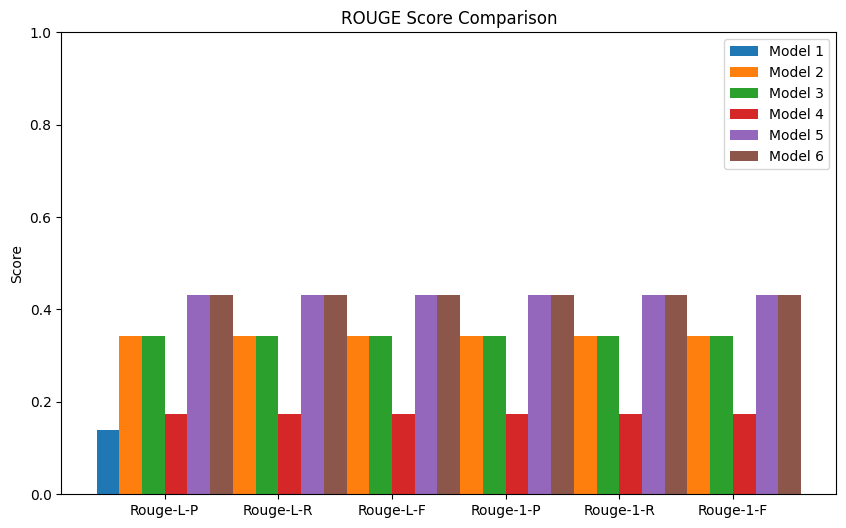

In [ ]:
plot_data(data)

In [27]:
prompt4 = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
data_zero_shot = evaluate_model(
        model3,
        test_loader,
        device="cuda",
        bert=False,
        tokenizer=tokenizer3,
        prompt=prompt4,
        promptsuff = "[AGENT]"
    )


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: The newly minted millionaire was reported to have just returned from a holiday with his family when 
Prediction:  My name is [NAME]. I am the agent for [ADDRESS] of the winning client. I am the agent for [ADDRESS] of the winning client. I am the agent for [ADDRESS] of the winning client. I am the agent for
Target: A New Zealand toddler has won NZ$1m ($726,600; £560,700) in Bonus Bonds prize money - the youngest ever winner of the investment lottery scheme.
[['my', 'name', 'is', 'name', 'i', 'am', 'the', 'agent', 'for', 'address', 'of', 'the', 'winning', 'client', 'i', 'am', 'the', 'agent', 'for', 'address', 'of', 'the', 'winning', 'client', 'i', 'am', 'the', 'agent', 'for', 'address', 'of', 'the', 'winning', 'client', 'i', 'am', 'the', 'agent', 'for'], ['the', '2018', 'ryder', 'cup', 'is', 'in', 'full', 'swing', 'with', 'the', 'european', 'team', 's', '20th', 'match', 'up', 'against', 'the', 'americans', 'the', 'two', 'sides', 'have', 'met', 'twice', 'before', 'with', 'the', 'amer

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: London Fire Brigade said it was called to the arena on Millennium Way, Greenwich, at about 11:15 BST
Prediction:  We're looking for a 19-year-old man, about 5ft 10in tall, with brown hair, brown eyes, and a slim build. He was wearing a black shirt, a black belt, black jeans, black shoes
Target: More than 1,200 people were evacuated from the O2 Arena in London due to a fire at a restaurant.
[['we', 're', 'looking', 'for', 'a', '19', 'year', 'old', 'man', 'about', '5ft', '10in', 'tall', 'with', 'brown', 'hair', 'brown', 'eyes', 'and', 'a', 'slim', 'build', 'he', 'was', 'wearing', 'a', 'black', 'shirt', 'a', 'black', 'belt', 'black', 'jeans', 'black', 'shoes'], ['we', 'have', 'had', 'a', 'number', 'of', 'inquiries', 'into', 'the', 'murder', 'of', 'mrs', 'furneaux', 'and', 'we', 'have', 'received', 'a', 'number', 'of', 'enquiries', 'from', 'the', 'public', 'we', 'will', 'keep', 'you', 'informed', 'of', 'any', 'developments'], ['is', 'this', 'the', 'man', 'you', 'are', 'looking', 'for'

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: It will connect the A4232 at the Queensgate roundabout with the Ocean Way roundabout in Tremorfa.
Th
Prediction:  The Eastern Bay Link will be a major improvement to the route between Cardiff and the harbour, meaning commuters will be able to travel between the two towns in half an hour.
It is expected to open after rush hour at about 19:00
Target: A £57m road linking Cardiff Bay and the east of the city will officially open on Thursday.
[['the', 'eastern', 'bay', 'link', 'will', 'be', 'a', 'major', 'improvement', 'to', 'the', 'route', 'between', 'cardiff', 'and', 'the', 'harbour', 'meaning', 'commuters', 'will', 'be', 'able', 'to', 'travel', 'between', 'the', 'two', 'towns', 'in', 'half', 'an', 'hour', 'it', 'is', 'expected', 'to', 'open', 'after', 'rush', 'hour', 'at', 'about', '19', '00'], ['i', 'am', 'happy', 'to', 'say', 'that', 'i', 'have', 'been', 'given', 'more', 'time', 'to', 'question', 'the', 'suspect', 'i', 'am', 'happy', 'to', 'say', 'that', 'there', 'is', 'a', 'reaso

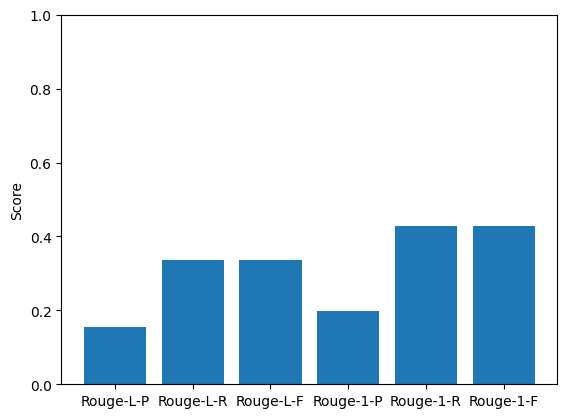

In [ ]:
plot_data(data_zero_shot)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
from peft import PeftModel
model_path = './drive/MyDrive/models/ft'
ft_model = PeftModel.from_pretrained(model3, model_path)


In [30]:
data_ft = evaluate_model(ft_model, test_loader, 'cuda', bert=False, tokenizer = tokenizer3, prompt = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]", promptsuff = "[AGENT]")

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: The project at Ffrwd Farm Nature Reserve, Pembrey, is part of a wider ongoing water vole strategy fo
Prediction:  Click to read the full story.
### Summary
Natural Resources Wales has released a report warning about the decline of water voles in south Wales. The report says the species has been affected by a range of environmental factors.
Target: Water voles are being reintroduced at a Carmarthenshire nature reserve.
[['click', 'to', 'read', 'the', 'full', 'story', 'summary', 'natural', 'resources', 'wales', 'has', 'released', 'a', 'report', 'warning', 'about', 'the', 'decline', 'of', 'water', 'voles', 'in', 'south', 'wales', 'the', 'report', 'says', 'the', 'species', 'has', 'been', 'affected', 'by', 'a', 'range', 'of', 'environmental', 'factors'], ['the', 'fire', 'at', 'the', 'o2', 'arena', 'in', 'london', 'was', 'brought', 'under', 'control', 'and', 'no', 'one', 'was', 'injured', 'said', 'a', 'spokesman', 'summary', 'a', 'fire', 'outside', 'a', 'music', 'festival', 'has', 'been

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: Edward Furneaux, 74, died after crashing his car into a tree in Kewstoke Road, Worle, on the morning
Prediction:  Police have arrested a man on suspicion of murder in connection with the death of Mrs Furneaux.
### Summary
A man has been arrested on suspicion of murder after the death of a woman in Dorset. The victim's body has been found in
Target: A husband and wife who died in an apparent murder-suicide in North Somerset have been named.
[['police', 'have', 'arrested', 'a', 'man', 'on', 'suspicion', 'of', 'murder', 'in', 'connection', 'with', 'the', 'death', 'of', 'mrs', 'furneaux', 'summary', 'a', 'man', 'has', 'been', 'arrested', 'on', 'suspicion', 'of', 'murder', 'after', 'the', 'death', 'of', 'a', 'woman', 'in', 'dorset', 'the', 'victim', 's', 'body', 'has', 'been', 'found', 'in'], ['the', 'man', 'has', 'been', 'arrested', 'on', 'suspicion', 'of', 'murder', 'in', 'connection', 'with', 'the', 'death', 'of', 'a', 'man', 'in', 'dorking', 'on', '15', 'may', 'summary', 'a', 'man'

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: Police were called to Honeywell Drive, in Stepps, just after 21:00 on Sunday.
The man is said to be 
Prediction:  The man is said to be in a stable condition in hospital.[AGENT] The man is said to be in a stable condition in hospital.[AGENT] The man is said to be in a stable condition in hospital.[AGENT] The man is said to
Target: A 42-year-old man is being treated in hospital after being shot in a targeted attack near Glasgow.
[['the', 'man', 'is', 'said', 'to', 'be', 'in', 'a', 'stable', 'condition', 'in', 'hospital', 'agent', 'the', 'man', 'is', 'said', 'to', 'be', 'in', 'a', 'stable', 'condition', 'in', 'hospital', 'agent', 'the', 'man', 'is', 'said', 'to', 'be', 'in', 'a', 'stable', 'condition', 'in', 'hospital', 'agent', 'the', 'man', 'is', 'said', 'to'], ['the', 'winner', 'of', 'the', 'nz', '1m', 'bonus', 'bond', 'was', 'announced', 'at', 'a', 'ceremony', 'in', 'singapore', 'summary', 'a', '7', 'year', 'old', 'boy', 'has', 'won', '1m', 'in', 'a', 'lottery', 'in', 'singapore

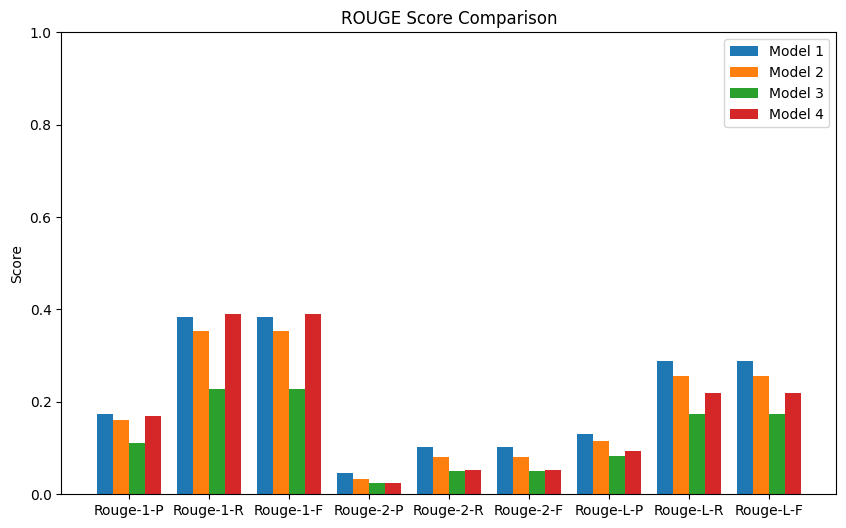

[0.11041751 0.22883623 0.22883623 0.02463508 0.05078704 0.05078704
 0.0834852  0.17479856 0.17479856]
[0.17483755 0.38401107 0.38401107 0.04617178 0.10199683 0.10199683
 0.12965541 0.28907081 0.28907081]


In [31]:
plot_data([data_ft, data, data_zero_shot, loss])
print(data_zero_shot)
print(data_ft)